# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Reframed data task
The objective of this task is to frame a supervised regression problem with the target variable being the price of used cars. Using the provided dataset, we aim to identify which vehicle features, such as year, mileage, manufacturer, condition, and title status, etc., have the most significant influence on pricing. This will be done through statistical analysis and by evaluating feature importance in predictive models. Additionally, we will train and compare several machine learning models, including Linear Regression, Ridge, and Lasso, to accurately predict used car prices based on these key attributes.

##### Research questions
* Which vehicle features (e.g., year, title status, condition, mileage) have the greatest impact on used car prices?
* How well can we predict used car prices using this dataset, and what is the model’s expected error?

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display="diagram")


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Step 1:
Load the dataset and inspect the structure by viewing column names, data types, and non-null counts.

In [13]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Step 2:
Display summary statistics of the dataset to understand the distribution and central tendencies of numerical features.

In [16]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


#### Step 3:
Display the first 5 rows.

In [19]:
df.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


#### Step 4:
Display the total missing value percentages per column. 

In [22]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].round(2).sort_values(ascending=False)
print(missing_percent)

size            71.77
cylinders       41.62
condition       40.79
VIN             37.73
drive           30.59
paint_color     30.50
type            21.75
manufacturer     4.13
title_status     1.93
model            1.24
odometer         1.03
fuel             0.71
transmission     0.60
year             0.28
dtype: float64


##### Step 4.1
The 'size' column will be dropped due to having more than 70% missing values, which makes it unreliable for analysis. Additionally, based on domain knowledge, the 'VIN' and 'id' columns are unique identifiers and are unlikely to have any meaningful impact on the car’s price. The 'region','model', and 'state' columns are also dropped to avoid large number of columns after applying the One-hot encoding.

In [25]:
df_dropped = df.drop(columns=['size','VIN','id','region','model','state'])
df_clean = df_dropped.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117169 entries, 31 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         117169 non-null  int64  
 1   year          117169 non-null  float64
 2   manufacturer  117169 non-null  object 
 3   condition     117169 non-null  object 
 4   cylinders     117169 non-null  object 
 5   fuel          117169 non-null  object 
 6   odometer      117169 non-null  float64
 7   title_status  117169 non-null  object 
 8   transmission  117169 non-null  object 
 9   drive         117169 non-null  object 
 10  type          117169 non-null  object 
 11  paint_color   117169 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 11.6+ MB


#### Step 5
Use plots to detect the potential relationships between each of the numeric features and the price.

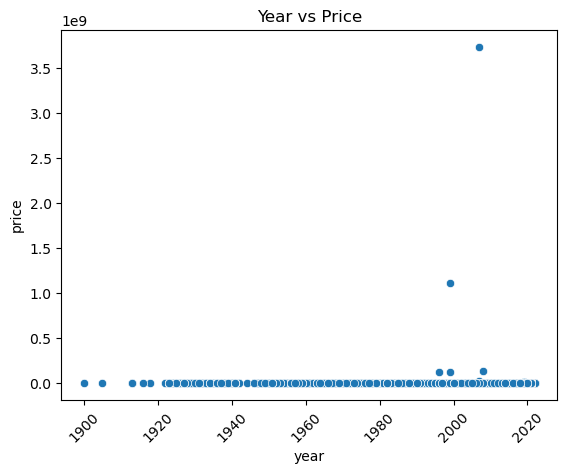

In [28]:
sns.scatterplot(data=df_clean, x='year',y='price')
plt.title('Year vs Price')
plt.xticks(rotation = 45)
plt.show()

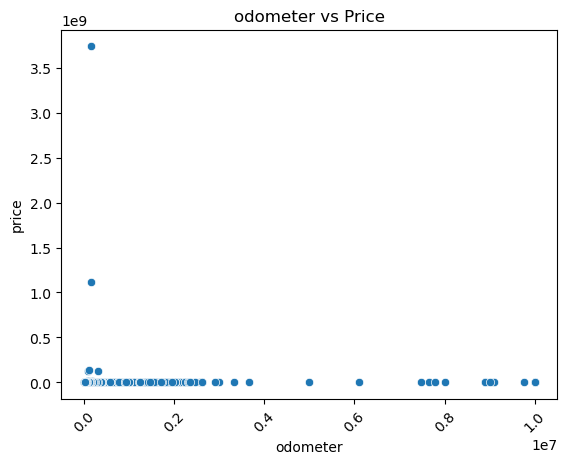

In [30]:
sns.scatterplot(data=df_clean, x='odometer',y='price')
plt.title('odometer vs Price')
plt.xticks(rotation = 45)
plt.show()

#### Step 6
Use plots to detect the potential relationships between each of the non-numeric features and the price.

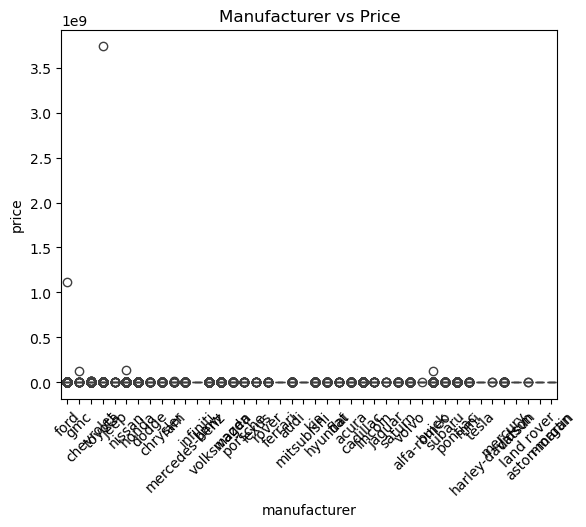

In [34]:
sns.boxplot(data=df_clean, x='manufacturer',y='price')
plt.title('Manufacturer vs Price')
plt.xticks(rotation = 45)
plt.show()

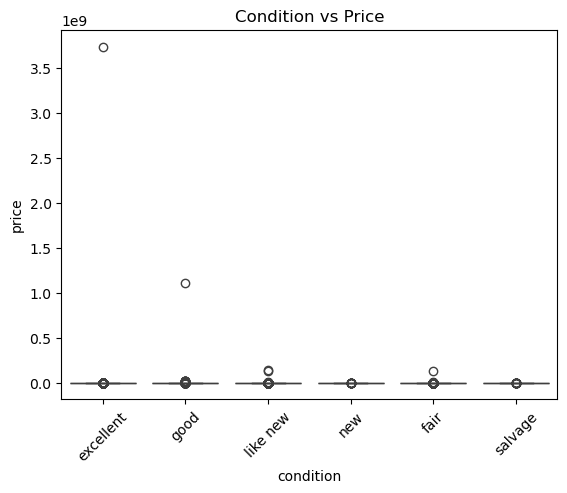

In [36]:
sns.boxplot(data=df_clean, x='condition',y='price')
plt.title('Condition vs Price')
plt.xticks(rotation = 45)
plt.show()

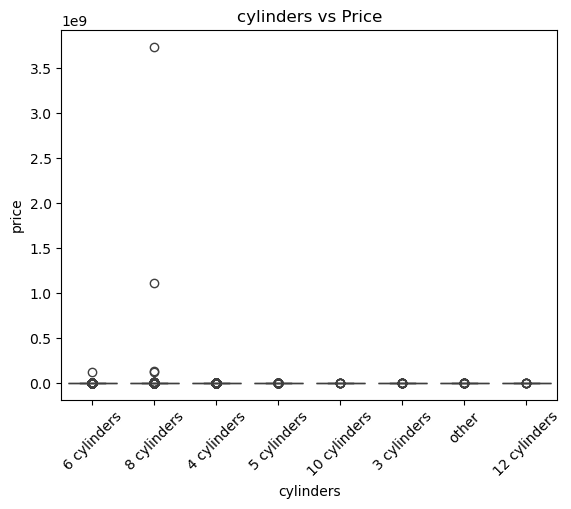

In [38]:
sns.boxplot(data=df_clean, x='cylinders',y='price')
plt.title('cylinders vs Price')
plt.xticks(rotation = 45)
plt.show()

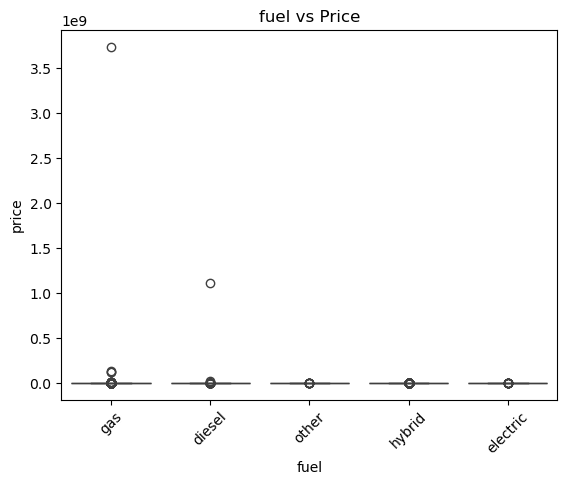

In [40]:
sns.boxplot(data=df_clean, x='fuel',y='price')
plt.title('fuel vs Price')
plt.xticks(rotation = 45)
plt.show()

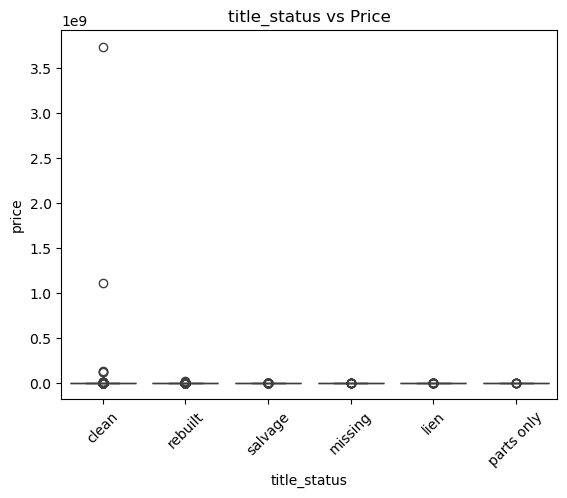

In [42]:
sns.boxplot(data=df_clean, x='title_status',y='price')
plt.title('title_status vs Price')
plt.xticks(rotation = 45)
plt.show()

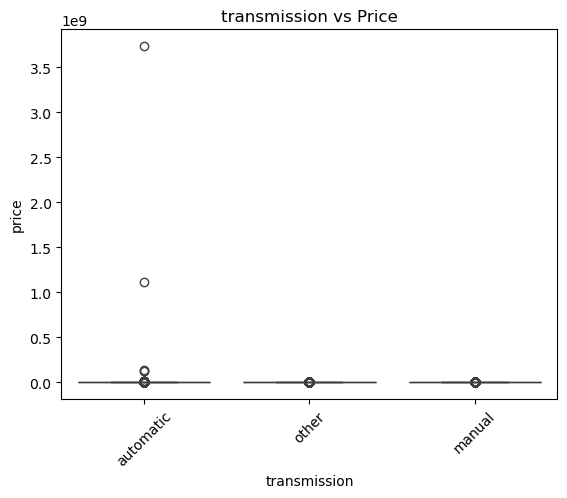

In [44]:
sns.boxplot(data=df_clean, x='transmission',y='price')
plt.title('transmission vs Price')
plt.xticks(rotation = 45)
plt.show()

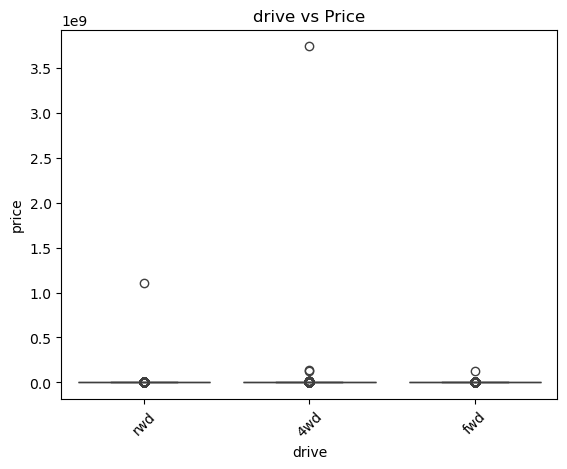

In [46]:
sns.boxplot(data=df_clean, x='drive',y='price')
plt.title('drive vs Price')
plt.xticks(rotation = 45)
plt.show()

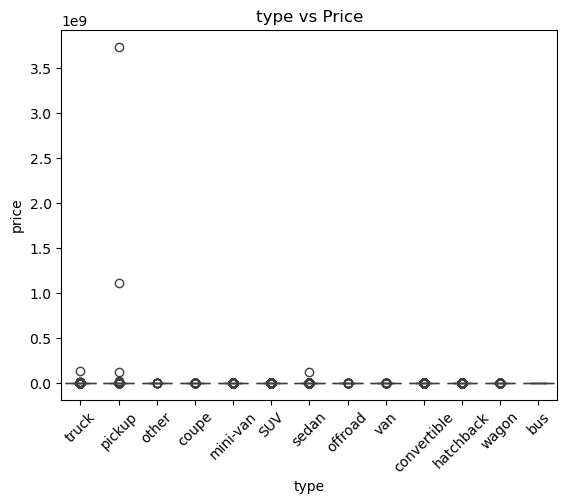

In [48]:
sns.boxplot(data=df_clean, x='type',y='price')
plt.title('type vs Price')
plt.xticks(rotation = 45)
plt.show()

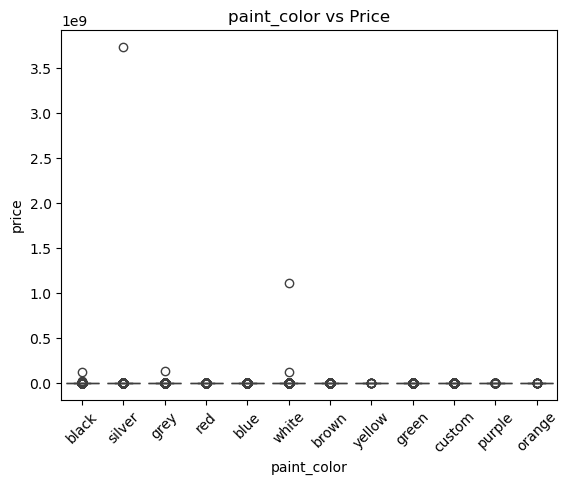

In [50]:
sns.boxplot(data=df_clean, x='paint_color',y='price')
plt.title('paint_color vs Price')
plt.xticks(rotation = 45)
plt.show()

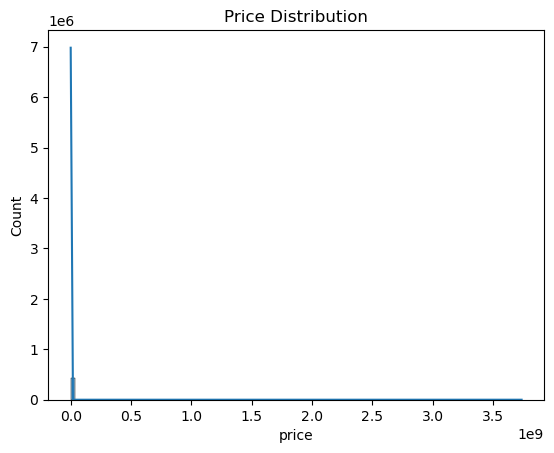

In [53]:
sns.histplot(df_dropped['price'], bins=100, kde=True)
plt.title('Price Distribution')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

##### Remove outliers
- Remove outliers from 'price' column
- Remove outliers from 'odometer' column

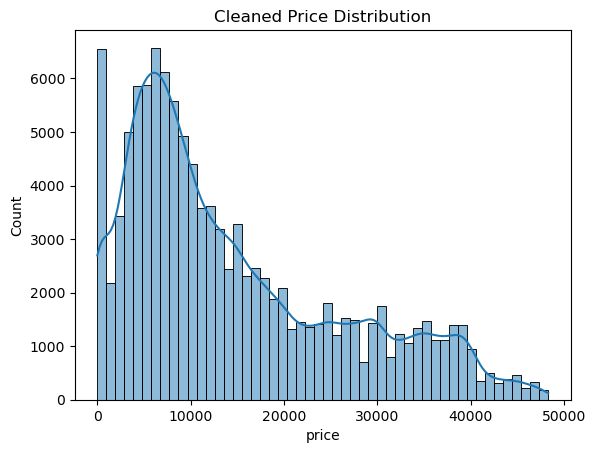

In [59]:
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

df_clean_removed_outliers = remove_outliers_iqr(df_clean, 'price')
df_clean_removed_outliers = remove_outliers_iqr(df_clean_removed_outliers, 'odometer')
sns.histplot(df_clean_removed_outliers['price'], bins=50, kde=True)
plt.title('Cleaned Price Distribution')
plt.show()

##### Other columns
Based on domain knowledge, the 'manufacturer', 'model', 'condition','title_status', and 'transmission' will affect the price of used cars significantly. However, since there are too many unique values of 'model', here we only include the 'manufacturer','condition','title_status', and 'transmission' columns.

In [62]:
categorical_cols = ['manufacturer','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color'] 
df_encoded = pd.get_dummies(df_clean_removed_outliers, columns=categorical_cols, drop_first=True)
df_encoded.head()

,price,year,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
31,15000,2013.0,128000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32,27990,2012.0,68696.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33,34590,2016.0,29499.0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
34,35000,2019.0,43000.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
35,29990,2016.0,17302.0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [64]:
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90949 entries, 7027 to 15795
Data columns (total 91 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          90949 non-null  float64
 1   odometer                      90949 non-null  float64
 2   manufacturer_alfa-romeo       90949 non-null  float64
 3   manufacturer_aston-martin     90949 non-null  float64
 4   manufacturer_audi             90949 non-null  float64
 5   manufacturer_bmw              90949 non-null  float64
 6   manufacturer_buick            90949 non-null  float64
 7   manufacturer_cadillac         90949 non-null  float64
 8   manufacturer_chevrolet        90949 non-null  float64
 9   manufacturer_chrysler         90949 non-null  float64
 10  manufacturer_datsun           90949 non-null  float64
 11  manufacturer_dodge            90949 non-null  float64
 12  manufacturer_ferrari          90949 non-null  float64
 13  man

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

##### LinearRegression

In [73]:
lng = LinearRegression()
lng.fit(X_train, y_train)

LinearRegression()

##### Ridge regression 

In [76]:
ridge = Ridge()
param_grid = {'alpha':[0.01, 0.1, 1, 10, 100]}
gridsearchcv_grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
gridsearchcv_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

##### Lasso regression 

In [79]:
lasso = Lasso()
param_grid_lasso = {'alpha':[0.01, 0.1, 1, 10, 100]}
gridsearchcv_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
gridsearchcv_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

##### Random Forest

In [82]:
rfregression = RandomForestRegressor(n_jobs=-1, random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}
# The GridSearchCV is extremely slow. Therefore, I use RandomizedSearchCV here.
randomizedsearch_rf = RandomizedSearchCV(estimator=rfregression, param_distributions=param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_iter=10)
randomizedsearch_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [50, 100, 150]},
                   scoring='neg_root_mean_squared_error')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [85]:
lng_predict = lng.predict(X_test)
lng_error = mean_squared_error( y_test, lng_predict)
print(np.sqrt(lng_error))
coeff_lng = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lng.coef_
})

print(coeff_lng)

7477.780593176986
                      Feature  Coefficient
0                        year  2473.658485
1                    odometer -4624.964844
2     manufacturer_alfa-romeo    80.757771
3   manufacturer_aston-martin    71.086980
4           manufacturer_audi  -113.961693
..                        ...          ...
86         paint_color_purple    10.666977
87            paint_color_red  -151.158334
88         paint_color_silver  -399.816616
89          paint_color_white    75.276972
90         paint_color_yellow     2.164702

[91 rows x 2 columns]


In [87]:
ridge_predict = gridsearchcv_grid.predict(X_test)
ridge_error = mean_squared_error(y_test, ridge_predict)
print(np.sqrt(ridge_error))
print(gridsearchcv_grid.best_params_)
best_model_grid = gridsearchcv_grid.best_estimator_
coef_ridge = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model_grid.coef_
})

print(coef_ridge)

7477.691118119639
{'alpha': 10}
                      Feature  Coefficient
0                        year  2473.404779
1                    odometer -4624.370599
2     manufacturer_alfa-romeo    81.043132
3   manufacturer_aston-martin    71.143182
4           manufacturer_audi  -112.422881
..                        ...          ...
86         paint_color_purple    10.646025
87            paint_color_red  -151.095989
88         paint_color_silver  -399.764371
89          paint_color_white    75.265515
90         paint_color_yellow     2.158726

[91 rows x 2 columns]


In [89]:
lasso_predict = gridsearchcv_lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, lasso_predict)
print(np.sqrt(lasso_error))
print(gridsearchcv_lasso.best_params_)
best_model_lasso = gridsearchcv_lasso.best_estimator_
coef_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model_lasso.coef_
})

print(coef_lasso)

7477.709157708287
{'alpha': 0.1}
                      Feature  Coefficient
0                        year  2473.549002
1                    odometer -4624.847991
2     manufacturer_alfa-romeo    81.379690
3   manufacturer_aston-martin    71.171545
4           manufacturer_audi  -110.025774
..                        ...          ...
86         paint_color_purple    10.558393
87            paint_color_red  -150.894480
88         paint_color_silver  -399.500904
89          paint_color_white    75.430556
90         paint_color_yellow     2.100968

[91 rows x 2 columns]


4364.672145038818
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': None}
                  Feature  Coefficient
0                    year     0.239832
1                odometer     0.236783
65     transmission_other     0.087495
66              drive_fwd     0.032205
50  cylinders_4 cylinders     0.031299
53  cylinders_8 cylinders     0.026594
44         condition_good     0.025868
56               fuel_gas     0.022349
76             type_sedan     0.020788
75            type_pickup     0.020228
77             type_truck     0.017775
67              drive_rwd     0.015966
43         condition_fair     0.014047
52  cylinders_6 cylinders     0.012075
89      paint_color_white     0.011174


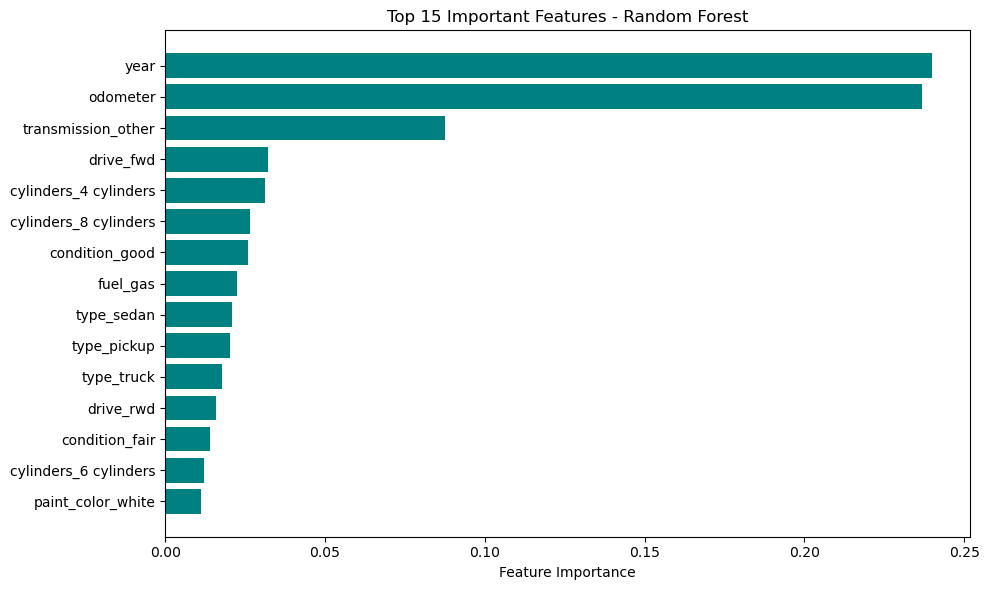

In [91]:
rf_predict = randomizedsearch_rf.predict(X_test)
rf_error = mean_squared_error(y_test, rf_predict)
print(np.sqrt(rf_error))
print(randomizedsearch_rf.best_params_)
best_model_rf = randomizedsearch_rf.best_estimator_
coef_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model_rf.feature_importances_
}).sort_values(by='Coefficient', ascending=False)

print(coef_rf.head(15))
top_features = coef_rf.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color='teal')
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Random Forest')
plt.tight_layout()
plt.show()

##### Here is the comparison table of all above models:

- **Linear Regression**  
  - RMSE: $7,477.78  
  - Notes: Fast, but less accurate  

- **Ridge Regression**  
  - RMSE: $7,477.69  
  - Notes: Similar to Linear, slightly improved  

- **Lasso Regression**  
  - RMSE: $7,477.71  
  - Notes: Time-consuming, minimal improvement  

- **Random Forest**  
  - **RMSE: $4,364.67**  
  - **Notes: Best performer, highly accurate**

##### Business Objective Recap
The goal was to **predict used car prices** and **identify main factors that influence pricing**, helping the used car dealers gain insight into vehicle valuation.

##### Model Performance
The **Random Forest Regressor** achieved the best performance with:

- **Test RMSE**: $4,364.67  
- **Best Parameters**: `n_estimators=50`, `max_features='sqrt'`, `max_depth=None`  

This result significantly outperforms linear models such as Linear Regression, Ridge, and Lasso (all around **$7,477 RMSE**), indicating Random Forest is better suited for capturing non-linear patterns in this dataset.

##### Feature Importance Insights
The model reveals that **year and mileage** are the top predictors of price:

- `year` (importance: 0.239832)
- `odometer` (importance: 0.236783)
- `transmission`, `drive`, and `engine cylinders`
- `fuel` and even `type`, such as sedan, pickup, etc.

##### Interpretation vs. Performance
- **Random Forest** offers high accuracy but limited interpretability.
- **Linear models** are more interpretable but underperform in prediction.
- Depending on client needs (explainability vs. accuracy), the model choice may vary.

##### Revisiting Earlier Phases?
- **No major gaps found**, but we could:
  - Drop low-importance features to simplify the model.
  - Consider using SHAP values to improve interpretability.
  - Tune further if more accuracy is needed.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

##### Objective
To help used car dealers **better understand what drives car prices**, and make smarter inventory and pricing decisions.

##### Key Insights

1. **Most Influential Factors on Price:**
   - **Year of Manufacture** : Newer cars retain higher prices.
   - **Mileage (`odometer`)** : Lower mileage = higher value.
   - **Transmission Type** : Uncommon transmissions impact pricing.
   - **Drive Type & Engine Cylinders** :– Drive configuration and engine size contribute to value.
   - **Vehicle Condition** : As expected, better condition boosts value.
   - **Fuel Type & Body Type** : Gas cars and sedans/trucks show distinct trends.

2. **Price Prediction Accuracy:**
   - Our best model (Random Forest) predicts car prices with an average error of **~$4,364.67**, which is significantly better than traditional models.
   - This model accounts for non-linear trends and complex feature interactions.

##### Model Summary

- **Linear Regression**  
  - RMSE: $7,477.78  

- **Ridge Regression**  
  - RMSE: $7,477.69  

- **Lasso Regression**  
  - RMSE: $7,477.71  

- **Random Forest**  
  - **RMSE: $4,364.67**  

##### Recommendations for Dealers

- **Prioritize newer, low-mileage vehicles** : they retain more value.
- **Consider condition and transmission when buying/selling** : these features impact pricing.
- **Use this model as a pricing assistant** : to estimate fair market value.